<a href="https://colab.research.google.com/github/marcd123/Deep_Conv_Autoencoder/blob/main/Deep_Background_Remover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Autoencoders

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

import tensorflow_datasets as tfds
import cv2

## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [ ]:
(x_train, x_test) = tfds.load('rock_paper_scissors', split=['train', 'test'], as_supervised=True)
x_train = np.array([x[0] for x in tfds.as_numpy(x_train)])
x_test = np.array([x[0] for x in tfds.as_numpy(x_test)])

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
x_train = np.array([rgb2gray(x) for x in x_train])
x_test = np.array([rgb2gray(x) for x in x_test])

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape
x_test.shape

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete46MDI9/rock_paper_scissors-train.tfrecord


  0%|          | 0/2520 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete46MDI9/rock_paper_scissors-test.tfrecord


  0%|          | 0/372 [00:00<?, ? examples/s]

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


KeyboardInterrupt: ignored

## First example: Basic autoencoder
![Basic autoencoder results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/intro_autoencoder_result.png?raw=1)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [ ]:
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(90000, activation='sigmoid'),
      layers.Reshape((300, 300))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                shuffle=True,
                validation_data=(x_test, x_test))

Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Image denoising


![Image denoising results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/image_denoise_fmnist_results.png?raw=1)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [ ]:
(x_train, x_test) = tfds.load('rock_paper_scissors', split=['train', 'test'], as_supervised=True)
x_train = np.array([x[0] for x in tfds.as_numpy(x_train)])
x_test = np.array([x[0] for x in tfds.as_numpy(x_test)])

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
x_train = np.array([rgb2gray(x) for x in x_train])
x_test = np.array([rgb2gray(x) for x in x_test])

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# x_train = x_train[..., tf.newaxis]
# x_test = x_test[..., tf.newaxis]

print(x_train.shape)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteKCZ3MD/rock_paper_scissors-train.tfrecord


  0%|          | 0/2520 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteKCZ3MD/rock_paper_scissors-test.tfrecord


  0%|          | 0/372 [00:00<?, ? examples/s]

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
(2520, 300, 300)


Adding random noise to the images

In [ ]:
# noise_factor = 0.2
# x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
# x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

# x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
# x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

# def checkerboard(shape):
#     return (np.indices(shape).sum(axis=0) % 2)

def checkerboardv2(shape, kernel):
  board = np.ones(shape, dtype=np.uint8)

  for index, row in enumerate(board):
    step = 0 if int(index/kernel) % 2 else kernel
 
    while step < len(row) - 1:
      start = step
      end = min(start + kernel, len(row - 1))
      board[index][start:end] = 0
      step += kernel * 2

  return board

background = checkerboardv2((300, 300), 16)

In [ ]:
def apply_background(image):
  return np.where(
      (image > 0.94),
      background,
      image
  )

x_train_noisy = np.array([apply_background(x) for x in x_train])
x_test_noisy = np.array([apply_background(x) for x in x_test])

Plot the noisy images.


In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
plt.show()

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [ ]:
#Combine datasets
print(len(x_train), len(x_train_noisy), len(x_train) + len(x_train_noisy))

x_combined_train = np.concatenate((x_train, x_train_noisy))
x_combined_test = np.concatenate((x_test, x_test_noisy))
y_combined_train = np.concatenate((x_train, x_train))
y_combined_test = np.concatenate((x_test, x_test))

print(x_combined_train.shape)
del x_train
del x_test
del x_train_noisy
del x_test_noisy

2520 2520 5040
(5040, 300, 300)


### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(300, 300, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# autoencoder = Denoise()


class SemiDeepDenoise(Model):
  def __init__(self):
    super(SemiDeepDenoise, self).__init__()

    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(300, 300, 1)),
      layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D((2, 2), padding="same"),
      layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D((2, 2), padding="same")
    ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"),
      layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"),
      layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")
    ])
  
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# autoencoder = SemiDeepDenoise()


class DeepDenoise(Model):
  def __init__(self):
    super(DeepDenoise, self).__init__()

    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(300, 300, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2), padding='same'),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2), padding='same'),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
      layers.MaxPooling2D((2, 2), padding='same')    
    ])

    self.decoder = tf.keras.Sequential([
      layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
      layers.UpSampling2D((2, 2)),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
      layers.UpSampling2D((2, 2)),
      layers.Conv2D(16, (3, 3), activation='relu'),
      layers.UpSampling2D((2, 2)),
      layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')             
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = DeepDenoise()

In [ ]:
# autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
# print("x_train", x_train.shape)
# print("x_train_noisy", x_train_noisy.shape)
# print("x_test", x_test.shape)
# print("x_text_noisy", x_test_noisy.shape)

# Fit Autoencoder to non-noised data
# autoencoder.fit(x_train, x_train,
#                 epochs=50,
#                 batch_size=256,
#                 shuffle=True,
#                 validation_data=(x_test, x_test))

# Further fit Autoencoder to with noised data
# autoencoder.fit(x_train_noisy, x_train,
#                 epochs=50,
#                 batch_size=256,
#                 shuffle=True,
#                 validation_data=(x_test_noisy, x_test))

# Test on combined base and noisy dataset
autoencoder.fit(x_combined_train, y_combined_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_combined_test, y_combined_test))

Epoch 1/100
20/20 [==============================] - 39s 1s/step - loss: 0.5246 - val_loss: 0.3328
Epoch 2/100
20/20 [==============================] - 14s 694ms/step - loss: 0.3725 - val_loss: 0.3209
Epoch 3/100
20/20 [==============================] - 14s 704ms/step - loss: 0.3507 - val_loss: 0.3081
Epoch 4/100
20/20 [==============================] - 14s 713ms/step - loss: 0.3262 - val_loss: 0.2887
Epoch 5/100
20/20 [==============================] - 14s 693ms/step - loss: 0.2937 - val_loss: 0.2630
Epoch 6/100
20/20 [==============================] - 14s 690ms/step - loss: 0.2649 - val_loss: 0.2495
Epoch 7/100
20/20 [==============================] - 14s 693ms/step - loss: 0.2451 - val_loss: 0.2557
Epoch 8/100
20/20 [==============================] - 14s 698ms/step - loss: 0.2379 - val_loss: 0.2501
Epoch 9/100
20/20 [==============================] - 14s 711ms/step - loss: 0.2343 - val_loss: 0.2471
Epoch 10/100
20/20 [==============================] - 14s 703ms/step - loss: 0.2315 -

Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [ ]:
autoencoder.encoder.summary()

The decoder upsamples the images back from 7x7 to 28x28.

In [ ]:
autoencoder.decoder.summary()

Plotting both the noisy images and the denoised images produced by the autoencoder.

In [ ]:
# encoded_imgs = autoencoder.encoder(x_test).numpy()
# decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
# del x_combined_train
noisy_encoded_ims = autoencoder.encoder(x_combined_test[500:550]).numpy()
noisy_decoded_ims = autoencoder.decoder(noisy_encoded_ims).numpy()

In [ ]:
print(len(x_combined_test))

744


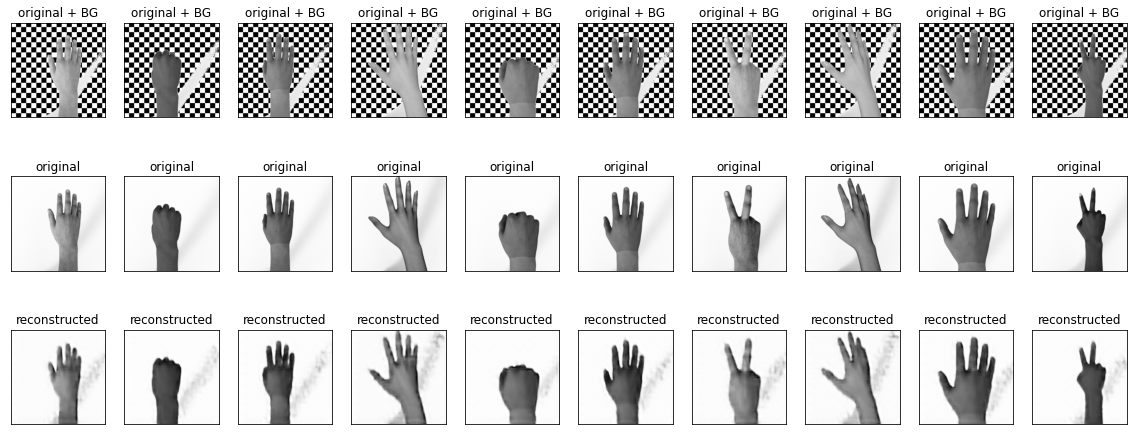

In [ ]:
n = 10
offset = 500
plt.figure(figsize=(20, 8))
for i in range(n):

    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("original + BG")
    plt.imshow(tf.squeeze(x_combined_test[i + offset]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original
    ax = plt.subplot(3, n, i + n + 1) 
    plt.title("original")
    plt.imshow(tf.squeeze(y_combined_test[i + offset]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + 2 * n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(noisy_decoded_ims[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

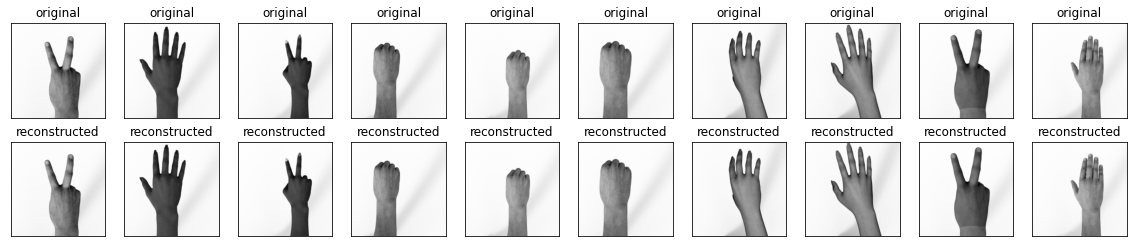

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original
    ax = plt.subplot(2, n, i + n + 1) 
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
fake = cv2.imread('fake.png', cv2.IMREAD_GRAYSCALE)
fake = cv2.resize(fake, (300, 300))
cv2.imwrite('fakescale.png', fake)

print(x_test_noisy.shape)
print(np.array([fake]).shape)
fake_set = np.array([fake])

encoded_imgs = autoencoder.encoder(fake_set).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()



In [ ]:
n = 1
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(fake_set[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original
    ax = plt.subplot(2, n, i + n + 1) 
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()